In [1]:
import torch

# checking if requires grad is true or not for tensor
t = torch.tensor(data=[1,2,3], dtype=torch.float32, requires_grad=True)
print(t.requires_grad)

t2 = torch.tensor(data=[[1,2],[4,5]], dtype=torch.float32)
print(t2.requires_grad)

True
False


In [2]:
import torch.nn as nn 

# creating empy tensor and then initializing it with xavier method
t = torch.empty(2,3)
nn.init.xavier_normal_(t)
t

tensor([[ 0.8238, -0.0216,  0.5966],
        [-0.0155,  0.1415,  1.0892]])

In [3]:
# initializing weights using xavier method

class XavierWeight(nn.Module):
    def __init__(self):
        super().__init__()

        self.w1 = torch.empty(2,3)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(3,2)
        nn.init.xavier_normal_(self.w2)

w = XavierWeight()
w.w1, w.w2

(tensor([[-0.4646,  0.0534, -0.3200],
         [ 0.0699, -0.2754,  0.7256]]),
 tensor([[-0.2159,  0.2289],
         [ 0.6215,  0.0220],
         [ 0.6244, -0.0735]]))

In [4]:
# creating tensors with requires_grad=True
# and the performing maths on them and then checking their grads using .backward method
w = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([0.5], requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.4])
z = torch.add(torch.mul(w,x), b)
loss = (y-z).pow(2).sum()

loss.backward()
print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

# verifying if we got correct gradient
print(2 * x * ((w * x + b) - y))

dL/dw :  tensor([-1.4000])
dL/db :  tensor([-1.0000])
tensor([-1.4000], grad_fn=<MulBackward0>)


In [5]:
import torch.nn as nn 

# using nn.sequential to create a neural network

model = nn.Sequential(

    nn.Linear(4,16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [6]:
# let's apply xavier initialization to first layer of previous model

nn.init.xavier_uniform_(model[0].weight)

# applying l1 regularization to second layer
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

In [7]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

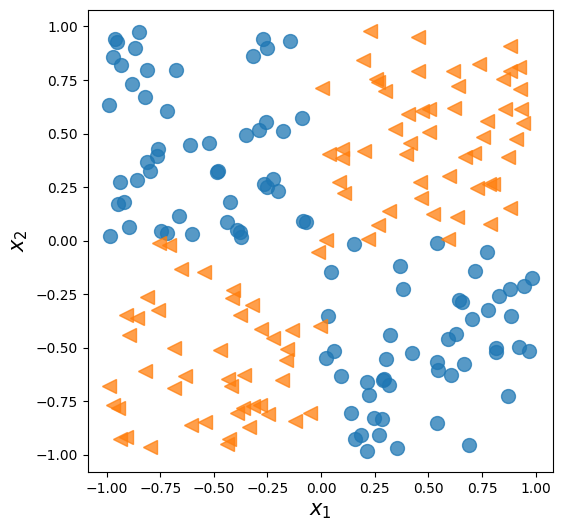

In [8]:
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

X = np.random.uniform(low=-1, high=1, size=(200,2))
y = np.ones(len(X))

y[X[:,0]*X[:,1]<0] = 0
# another way to do the same thing as above
# for i in range(len(X)):
#     if X[i,0] * X[i,1] < 0:
#         y[i] = 0

n_train = 100

X_train = torch.from_numpy(X[:n_train, :]).to(dtype=torch.float32)
y_train = torch.from_numpy(y[:n_train]).to(dtype=torch.float32)

X_valid = torch.from_numpy(X[n_train:, :]).to(dtype=torch.float32)
y_valid = torch.from_numpy(y[n_train:]).to(dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(X[y==0, 0], X[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(X[y==1, 0], X[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [9]:
model = nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [10]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, y_train)

batch_size = 2
torch.manual_seed(42)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [11]:
num_epoch = 200
def train(model, num_epoch, train_dl, X_valid, y_valid):
    loss_hist_train = [0] * num_epoch
    train_acc = [0] * num_epoch
    loss_hist_valid = [0] * num_epoch
    valid_acc = [0] * num_epoch

    for epoch in range(num_epoch):
        for x, y in train_dl:
            preds = model(x)[:,0]
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((preds>=0.5).float() == y).float()
            train_acc[epoch] += is_correct.mean()
        
        loss_hist_train[epoch] /= len(train_dl.dataset)/batch_size
        train_acc[epoch] /= len(train_dl.dataset)/batch_size
        pred = model(X_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        valid_acc[epoch] += is_correct.mean()
    
    return loss_hist_train, loss_hist_valid, train_acc, valid_acc

Text(0.5, 0, 'Epochs')

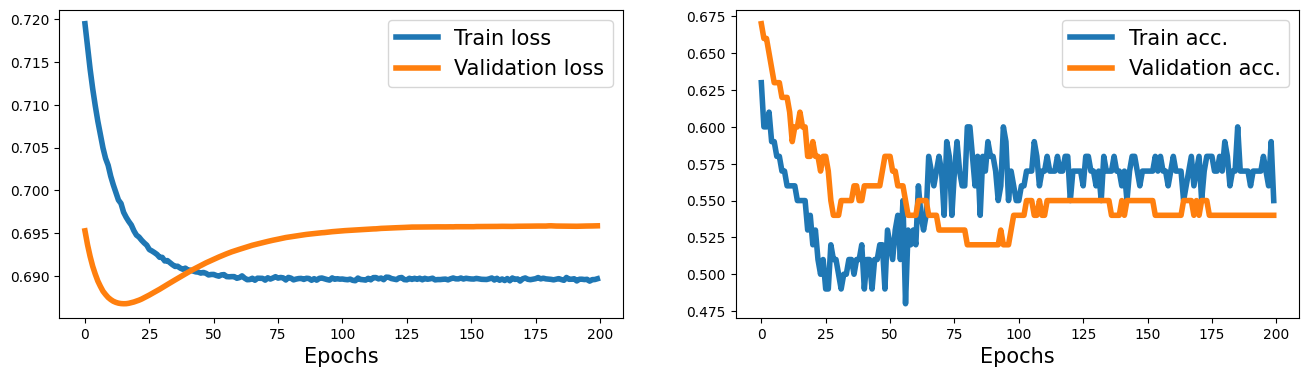

In [12]:
history = train(model, num_epoch, train_dl,
                X_valid, y_valid)

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [13]:
model = nn.Sequential(
    nn.Linear(2,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}, Size: {param.size()}, Values: \n{param.data}\n")

Layer: 0.weight, Size: torch.Size([4, 2]), Values: 
tensor([[-0.1418,  0.2809],
        [-0.6314,  0.4071],
        [-0.2198, -0.5379],
        [ 0.1034,  0.3426]])

Layer: 0.bias, Size: torch.Size([4]), Values: 
tensor([ 0.6119, -0.4319, -0.3480,  0.1360])

Layer: 2.weight, Size: torch.Size([4, 4]), Values: 
tensor([[ 0.1356,  0.1922,  0.2744, -0.1134],
        [ 0.2778,  0.3686, -0.1306,  0.3557],
        [ 0.2443,  0.4410, -0.2841, -0.2469],
        [-0.1446,  0.0254,  0.3001, -0.2854]])

Layer: 2.bias, Size: torch.Size([4]), Values: 
tensor([ 0.2503, -0.1792,  0.3021, -0.0237])

Layer: 4.weight, Size: torch.Size([1, 4]), Values: 
tensor([[-0.4380, -0.2751, -0.3619,  0.2480]])

Layer: 4.bias, Size: torch.Size([1]), Values: 
tensor([-0.3353])



In [14]:
history = train(model, num_epoch, train_dl, X_valid, y_valid)

Text(0.5, 0, 'Epochs')

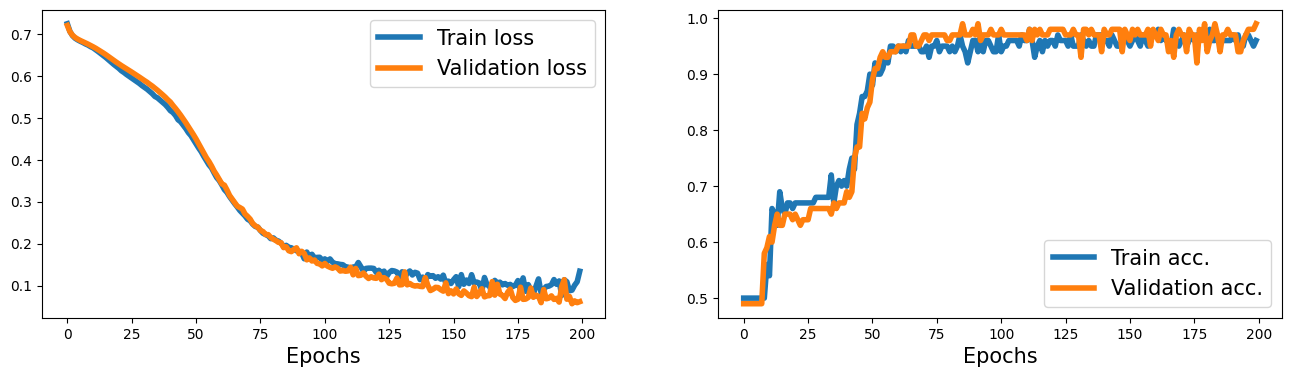

In [15]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [16]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}, Size: {param.size()}, Values: \n{param.data}\n")

Layer: 0.weight, Size: torch.Size([4, 2]), Values: 
tensor([[-1.0706,  0.9864],
        [-2.0703,  2.1471],
        [-2.1848, -1.0650],
        [ 0.6120,  1.9835]])

Layer: 0.bias, Size: torch.Size([4]), Values: 
tensor([ 0.8953, -0.0054, -0.2115,  0.1530])

Layer: 2.weight, Size: torch.Size([4, 4]), Values: 
tensor([[-0.7267,  1.2200, -0.7056, -0.8805],
        [ 0.4134,  1.1002, -0.4063, -0.4052],
        [-1.1228,  2.1195, -1.4797, -1.7438],
        [ 0.6597, -0.1901,  1.3356,  0.3334]])

Layer: 2.bias, Size: torch.Size([4]), Values: 
tensor([ 1.0292, -0.5427,  1.9171,  0.3064])

Layer: 4.weight, Size: torch.Size([1, 4]), Values: 
tensor([[-2.0045, -1.2583, -3.6452,  1.4934]])

Layer: 4.bias, Size: torch.Size([1]), Values: 
tensor([2.6467])



In [17]:
y_preds = model(X_valid).squeeze()
is_correct = ((y_preds>=0.5).float() == y_valid).float()

acc = is_correct.mean()
print(acc)

tensor(0.9900)


In [18]:
class Shinchan(nn.Module):
    def __init__(self):
        super().__init__()

        l1 = nn.Linear(2,4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4,4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4,1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.model_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.model_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        preds = self.forward(x).squeeze()

        return (preds >= 0.5).cpu().numpy().astype(int)
    
        
model = Shinchan()
model

Shinchan(
  (model_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [19]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epoch, train_dl, X_valid, y_valid)

Text(0.5, 0, '$x_1$')

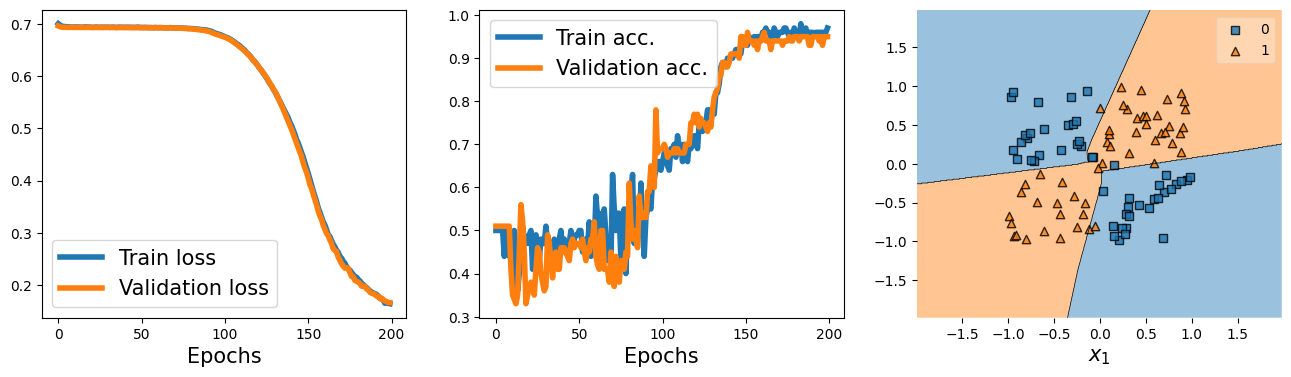

In [ ]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=X_valid.numpy(),
                      y=y_valid.numpy().astype(np.int_),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)